# Implementing Linear Regression

**Source code** [linearRegression.py]()

---

### What is the purpose of this blog post?

This blog post will cover the implementation of least-squares linear regression. It will also go over results from experimenting with LASSO regularization for overparameterized problems.

---

### Implementation

Linear regression is a model used to understand and quantify the relationship between variables and an outcome. 

This equation represents the empirical risk minimization problem that we want to solve.
<h4 align="center">$\hat{w} = argmin_{w}L(w) = argmin_{w}||X_w - y||^2_2$</h4>
 
To solve this problem, we first take the gradient with respects to $\hat{w}$. Eventually we want to solve for $\hat{w}$. The equation below is the explicit formula for $\hat{w}$.

<h4 align="center">$\hat{w} = {({X}^T{X})}^{-1}{X}^T{y}$</h4>


In our `LinearRegression` class, we implemented a `fit_analytic` method using this explicit formula for $\hat{w}$. We also implemented a `fit_gradient` method, which is gradient descent for linear regression. To implement `fit_gradient`, we used the formula

<h4 align="center">$\nabla{L(w) = {X}^T(Xw - y)}$</h4>

With each weight update, the gradient multiplied by the alpha value (default of 0.01) was subtracted from the weight to obtain a new weight.

---

### Preparation

Before starting, you need to load all of these libraries, modules, and functions.

In [141]:
from linearRegression import LinearRegression
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso

def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

def LR_data(n_train = 100, n_val = 100, p_features = 1, noise = .1, w = None):
    if w is None: 
        w = np.random.rand(p_features + 1) + .2
    
    X_train = np.random.rand(n_train, p_features)
    y_train = pad(X_train)@w + noise*np.random.randn(n_train)

    X_val = np.random.rand(n_val, p_features)
    y_val = pad(X_val)@w + noise*np.random.randn(n_val)
    
    return X_train, y_train, X_val, y_val

---

### Demo

To demonstrate that we've implemented `LinearRegression` correctly, we are going to test it on a data set that has 100 data points and 1 feature.

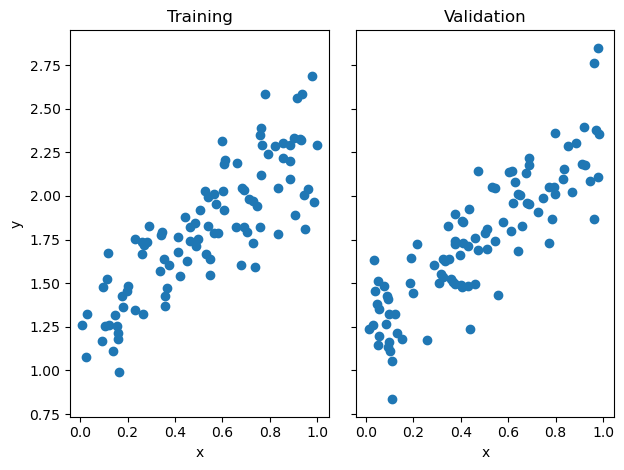

In [142]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

# create some data
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()

Here we fit our model using the class we implemented and test out the `fit_analytic` method.

In [144]:
LR = LinearRegression()
LR.fit_analytic(X_train, y_train) # I used the analytical formula as my default fit method

print(f"Training score = {LR.score(pad(X_train), y_train).round(4)}")
print(f"Validation score = {LR.score(pad(X_val), y_val).round(4)}")

Training score = 0.6965
Validation score = 0.7433


We can check the estimated weight vector **w**

In [146]:
LR.w

array([1.11225311, 1.22342203])

We can use the `fit_gradient` method we implemented to get the same value for **w** as well.

In [147]:
LR2 = LinearRegression()

LR2.fit_gradient(X_train, y_train, alpha = 0.01, max_iter = 1e2)
LR2.w

array([1.11236121, 1.22336123])

Here we plot the change in score over time.

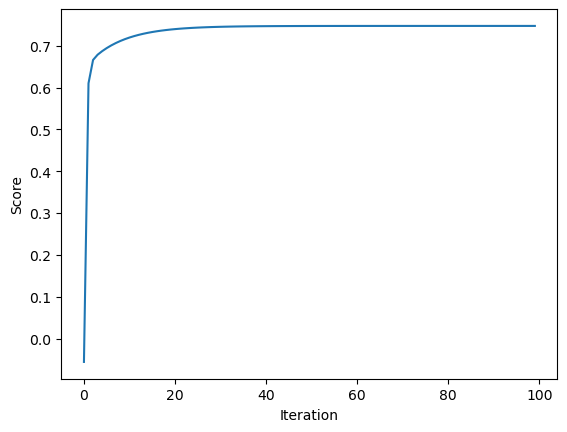

In [117]:
plt.plot(LR2.score_history)
labels = plt.gca().set(xlabel = "Iteration", ylabel = "Score")

### Experiments

Below we'll be looking at an experiment in which the number of features used, `p_features`, will increase while the number of training points, `n_train`, stays constant. 

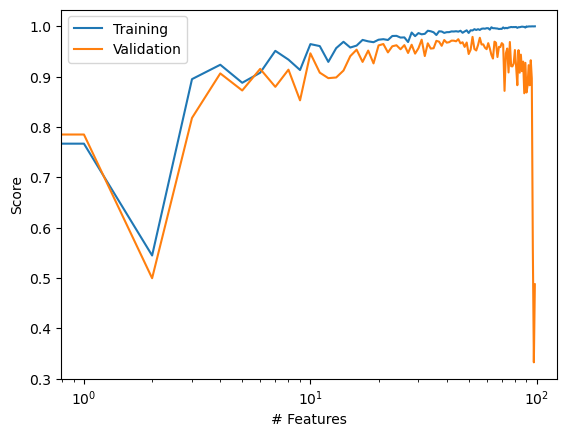

In [148]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    
    LR = LinearRegression()
    
    LR.fit_analytic(X_train, y_train)
    
    train_scores = LR.score(pad(X_train), y_train)
    val_scores = LR.score(pad(X_val), y_val)
    
    training_scores.append(train_scores)
    validation_scores.append(val_scores)
    
    p_features += 1
    
plt.plot(training_scores, label = "Training")
plt.plot(validation_scores, label = "Validation")

plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "# Features", ylabel = "Score")

You can see in the graph above that as the number of features used increased, the training score also increased. The validation score, however, experienced a lot of oscilation as the number of features increased and eventually the score dropped by the end. This is an indication of overfitting since the difference between our training score and validation score increased a lot with the number of features.

### LASSO Regularization

Below are some experiments done using the `LASSO` algorithm from `scikit-learn`. This algorithm has a modified loss function with a regularization term, which makes the entries of the weight vector **w** small. It tends to force entries of the weight vector to be exactly zero.

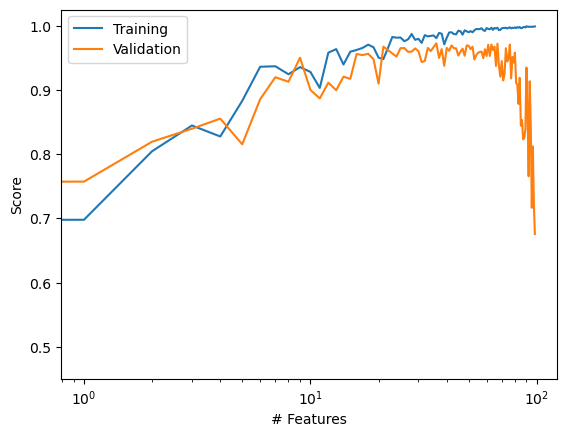

In [149]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    
    L = Lasso(alpha = 0.001)
    
    L.fit(X_train, y_train)
    
    train_scores = L.score(X_train, y_train)
    val_scores = L.score(X_val, y_val)
    
    training_scores.append(train_scores)
    validation_scores.append(val_scores)
    
    p_features += 1
    
plt.plot(training_scores, label = "Training")
plt.plot(validation_scores, label = "Validation")

plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "# Features", ylabel = "Score")

In this first experiment, we are working with 100 data points and 1 feature. The only difference between this and the previous experiment (Linear Regression) is the algorithm. With an alpha value of 0.001, the training accuracy increases with the number of features, but the validation accuracy decreases. We can see that the model was overfitting towards the end. These results are similar to the standard linear regression version.

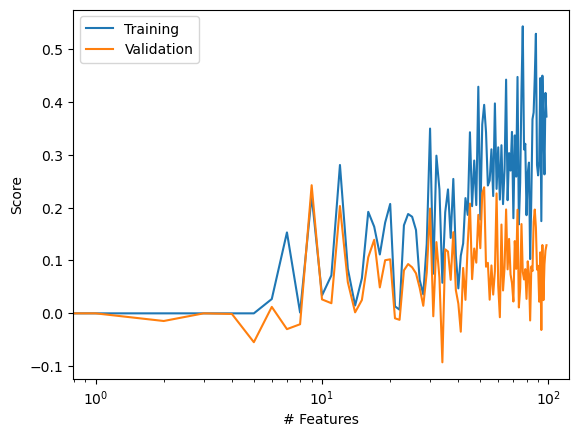

In [137]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    
    L = Lasso(alpha = 0.1)
    
    L.fit(X_train, y_train)
    
    train_scores = L.score(X_train, y_train)
    val_scores = L.score(X_val, y_val)
    
    training_scores.append(train_scores)
    validation_scores.append(val_scores)
    
    p_features += 1
    
plt.plot(training_scores, label = "Training")
plt.plot(validation_scores, label = "Validation")

plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "# Features", ylabel = "Score")

In this second experiment, we increased the alpha value to 0.1. With this increase, there is a lot more oscilation in both training and validation accuracy. Due to these oscilations, it seems that the training accuracy was not able to reach a perfect score of 1.0, like we observed in the linear regression version. The validation doesn't really dip either, though that's only because it never steadily increased in the first place.

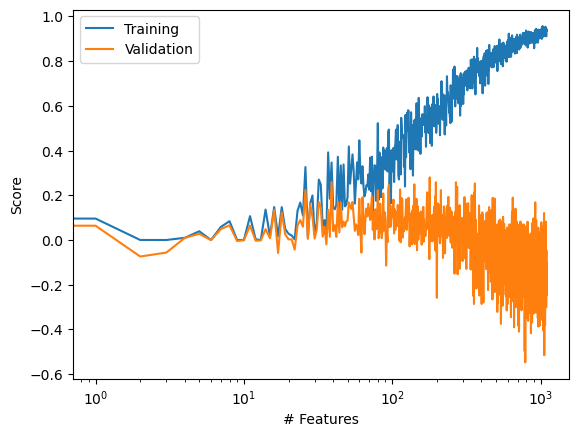

In [140]:

n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train + 999):
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    
    L = Lasso(alpha = 0.1)
    
    L.fit(X_train, y_train)
    
    train_scores = L.score(X_train, y_train)
    val_scores = L.score(X_val, y_val)
    
    training_scores.append(train_scores)
    validation_scores.append(val_scores)
    
    p_features += 1
    
plt.plot(training_scores, label = "Training")
plt.plot(validation_scores, label = "Validation")

plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "# Features", ylabel = "Score")

In this final experiment, the alpha value is set to 0.1 and the number of feature is going post the number of data points we have. You can see the oscilation that was present in the previous experiment, but there's more of a distinction in training scores and validation scores that's reminiscent of the linear regression version.